In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as mdt
import MDAnalysis as mda
import arcd
import arcd.distributed as arcdd

Tensorflow/Keras not available


In [3]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [4]:
LOGCONFIG

{'version': 1,
 'disable_existing_loggers': False,
 'formatters': {'standardFormatter': {'class': 'logging.Formatter',
   'format': '(%(levelname)s)%(name)s: %(message)s'},
  'msgOnly': {'class': 'logging.Formatter', 'format': '%(message)s'}},
 'handlers': {'stdout': {'class': 'logging.StreamHandler',
   'level': 'NOTSET',
   'formatter': 'msgOnly'},
  'warnout': {'class': 'logging.StreamHandler',
   'level': 'WARN',
   'formatter': 'standardFormatter'},
  'initf': {'class': 'logging.FileHandler',
   'level': 'INFO',
   'mode': 'w',
   'filename': 'initialization.log',
   'formatter': 'standardFormatter'},
  'stdf': {'class': 'logging.FileHandler',
   'level': 'INFO',
   'mode': 'w',
   'filename': 'simulation.log',
   'formatter': 'standardFormatter'}},
 'loggers': {'': {'level': 'INFO', 'handlers': ['stdf', 'warnout']},
  'openpathsampling.initialization': {'level': 'INFO',
   'handlers': ['initf'],
   'qualname': 'openpathsampling.initialization',
   'propagate': 0}}}

In [5]:
# you can either modify single values or use it as is to get the same setupt as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
logging.config.dictConfig(LOGCONFIG)

In [6]:
# first write out the inital TP as trr for gmx
initial_tp_mdt = mdt.load("../capped_alanine_dipeptide/ala_400K_TP_low_barrier.h5")

In [7]:
#initial_tp_mdt.save("/home/think/scratch/arcd_distributed/gmx_infiles/ala_400K_TP_low_barrier.trr")

# now the actual setup

In [8]:
n_chains = 3  # results in 6 gmx engines
scratch_dir = "/home/think/scratch/arcd_distributed/"

In [9]:
storage = arcd.Storage(os.path.join(scratch_dir, "storage.h5"))

# TODO: this is not very userfriendly!
 we should find a better way to initialize the storage (and also to pass the single modelstores to the movers)

In [10]:
storage.initialize_central_memory(n_chains=n_chains)

In [11]:
storage.central_memory[0].modelstore

In [12]:
# make a list of engines for the PathMovers
gro = os.path.join(scratch_dir, "gmx_infiles/conf.gro")
top = os.path.join(scratch_dir, "gmx_infiles/topol.top")

mdp = arcdd.MDP(os.path.join(scratch_dir, "gmx_infiles/md.mdp")) 

In [13]:
engines = [[arcdd.GmxEngine(gro_file=gro, top_file=top, mdrun_extra_args="-nt 2") for _ in range(2)] for _ in range(n_chains)]
# 2 way shooting: 2 engines per mover, n_chains movers because we have n_chains chains ;P

In [14]:
# states
def alpha_R(traj):
    traj = mdt.load(traj.trajectory_file, 
                    top=os.path.join(scratch_dir, "gmx_infiles/conf.gro"),  # mdt can not work with tprs, so we use theinitial gro for now
                    )
    psi = mdt.compute_dihedrals(traj, indices=[[6,8,14,16]])[:, 0]
    phi = mdt.compute_dihedrals(traj, indices=[[4,6,8,14]])[:, 0]
    state = np.full_like(psi, False, dtype=bool)
    # phi: -pi -> 0 
    # psi: > -50 but smaller 30 degree
    deg = 180/np.pi
    state[(phi <= 0) & (-50/deg <= psi) & (psi <= 30/deg)] = True
    return state


wrapped_alphaR = arcdd.trajectory.TrajectoryFunctionWrapper(alpha_R)


def C7_eq(traj):
    traj = mdt.load(traj.trajectory_file, 
                    top=os.path.join(scratch_dir, "gmx_infiles/conf.gro"),  # mdt can not work with tprs, so we use theinitial gro for now
                    )
    psi = mdt.compute_dihedrals(traj, indices=[[6,8,14,16]])[:, 0]
    phi = mdt.compute_dihedrals(traj, indices=[[4,6,8,14]])[:, 0]
    state = np.full_like(psi, False, dtype=bool)
    # phi: -pi -> 0 
    # psi: 120 -> 200 degree
    deg = 180/np.pi
    state[(phi <= 0) & ((120/deg <= psi) | (-160/deg >= psi))] = True
    return state


wrapped_C7_eq = arcdd.TrajectoryFunctionWrapper(C7_eq)

In [15]:
# descriptor_transform and model

# internal coordinates
def ic_transform(traj):
    traj = mdt.load(traj.trajectory_file, 
                    top=os.path.join(scratch_dir, "gmx_infiles/conf.gro"),  # mdt can not work with tprs, so we use theinitial gro for now
                    )
    pairs, triples, quadruples = arcd.coords.internal.generate_indices(traj.topology, source_idx=0)

    descriptors = arcd.coords.internal.transform(traj, pairs=pairs, triples=triples, quadruples=quadruples)
    return descriptors

wrapped_transform = arcdd.TrajectoryFunctionWrapper(ic_transform)

In [16]:
initial_TP = arcdd.Trajectory(os.path.join(scratch_dir, "gmx_infiles/ala_400K_TP_low_barrier.trr"),
                              os.path.join(scratch_dir, "gmx_infiles/conf.gro"))

In [17]:
await wrapped_alphaR(initial_TP)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True])

In [18]:
await wrapped_C7_eq(initial_TP)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [19]:
descript = await wrapped_transform(initial_TP)

In [20]:
cv_ndim = descript.shape[1]

In [21]:
import torch.nn.functional as F
import torch

In [22]:
ffnet = arcd.pytorch.networks.FFNet(n_in=cv_ndim,
                                    n_hidden=[int((cv_ndim) / i) for i in range(1,5)],  # 4 hidden layer pyramidal network
                                    activation=F.elu,
                                   )

resnet = arcd.pytorch.networks.ResNet(n_units=int(cv_ndim/ 4), n_blocks=2)

torch_model = arcd.pytorch.networks.ModuleStack(n_out=1,  # using a single output we will predict only p_B and use a binomial loss
                                                          # we could have also used n_out=n_states to use a multinomial loss and predict all states,
                                                          # but this is probably only worthwhile if n_states > 2 as it would increase the number of free parameters in the NN
                                                modules=[ffnet, resnet],  # modules is a list of initialized torch.nn.Modules from arcd.pytorch.networks
                                               )

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    torch_model = torch_model.to('cuda')

# choose and initialize an optimizer to train the model
optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-3)

In [23]:
# we take an ExpectedEfficiencyPytorchRCModel,
# this RCmodel scales the learning rate by the expected efficiency factor (1 - n_TP_true / n_TP_expected)**2
model = arcd.pytorch.EEScalePytorchRCModelAsync(nnet=torch_model,
                                                optimizer=optimizer,
                                                states=[wrapped_C7_eq, wrapped_alphaR],
                                                ee_params={'lr_0': 1e-3,  
                                                           'lr_min': 5e-5,  # lr_min = lr_0 / 20 is a good choice empirically
                                                           'epochs_per_train': 5,
                                                           'interval': 10,
                                                           'window': 100,
                                                           },
                                                descriptor_transform=wrapped_transform,
                                                cache_file=storage,
                                                )

In [24]:
arcd.pytorch.EEScalePytorchRCModel.__mro__

(arcd.pytorch.rcmodel.EEScalePytorchRCModel,
 arcd.pytorch.rcmodel.PytorchRCModel,
 arcd.base.rcmodel.RCModel,
 abc.ABC,
 object)

In [25]:
arcd.pytorch.EEScalePytorchRCModelAsync.__mro__

(arcd.pytorch.rcmodel.EEScalePytorchRCModelAsync,
 arcd.pytorch.rcmodel.PytorchRCModelAsync,
 arcd.base.rcmodel.RCModelAsync,
 arcd.base.rcmodel.RCModel,
 abc.ABC,
 object)

In [26]:
# need a list with initialized movers
movers = [[arcdd.TwoWayShootingPathMover(modelstore=storage.central_memory[i].modelstore,
                                         states=[wrapped_C7_eq, wrapped_alphaR],
                                         engines=engs,
                                         engine_config=mdp,
                                         walltime_per_part=0.01,
                                         T=mdp["ref-t"][0],
                                         )
           ] for i, engs in enumerate(engines)
         ]

In [27]:
trainset = arcd.TrainSet(n_states=2)

In [28]:
tasks = [arcdd.logic.TrainingTask(model=model, trainset=trainset),
         arcdd.logic.SaveTask(storage=storage, model=model, trainset=trainset)]

In [29]:
brain = arcdd.Brain(model=model, workdir=scratch_dir, storage=storage, movers=movers, mover_weights=[[1.], [1.], [1.]], tasks=tasks)

In [30]:
initial_step = arcdd.logic.MCstep(mover=None, stepnum=0, directory=os.path.join(scratch_dir, "gmx_infiles"), path=initial_TP, accepted=True)

In [31]:
for c in brain.chains:
    c.current_step = initial_step
    c.chainstore.append(initial_step)  # save the initial step as first step of every chain

In [32]:
#await brain.run_for_n_steps(200)
await brain.run_for_n_accepts(50)

/home/think/.conda/envs/arcd_dev_3_2021/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)
/home/think/.conda/envs/arcd_dev_3_2021/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

In [33]:
print(model.log_train_decision[-1])

[False, 1.660500791562755e-05, 5, None]


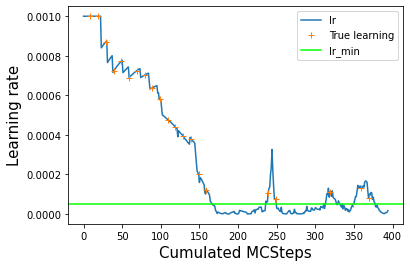

In [34]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('Cumulated MCSteps', size=15);
plt.ylabel('Learning rate', size=15);

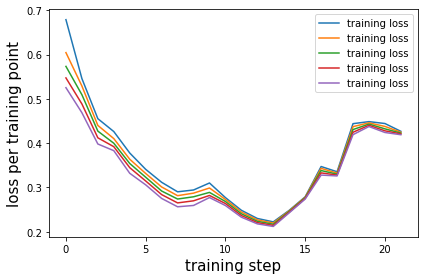

In [35]:
# the model losses at each step where it trained
# this will be epochs_per_training loss values per training
plt.plot(model.log_train_loss, label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('training step', size=15)
plt.tight_layout()

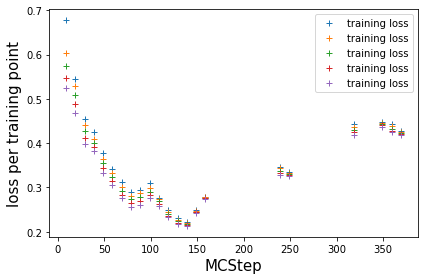

In [36]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

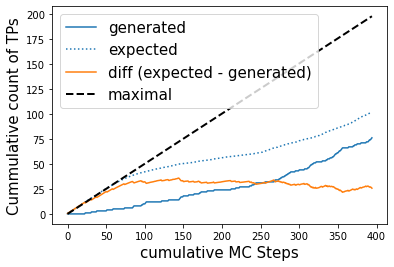

In [37]:
# plot efficiency, expected efficiency and accepts
# Note: this will only work for models with n_out=1, due to the way we calculate p(TP|x)

p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
#plt.plot(np.cumsum(accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (expected - generated)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=15);
plt.ylabel('Cummulative count of TPs', size=15)
plt.xlabel('cumulative MC Steps', size=15);